In [3]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

from math import exp
from numpy import sign

import json
import re
import ftfy
import nltk
import h5py

from nltk.corpus import stopwords
from nltk import PorterStemmer

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from gensim.models import KeyedVectors

from keras.models import load_model
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [2]:
#Reproducibility

np.random.seed(1234)

DEPRES_NROWS = 3200  # number of rows to read from DEPRESSIVE_TWEETS_CSV
RANDOM_NROWS = 12000 # number of rows to read from RANDOM_TWEETS_CSV
MAX_SEQUENCE_LENGTH = 140 # Max tweet size
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.6
TEST_SPLIT = 0.2
LEARNING_RATE = 0.1
EPOCHS= 10

In [3]:
DEPRESSIVE_TWEETS_CSV = 'DepressedTweets.csv'
RANDOM_TWEETS_CSV = 'RandomSentimentTweets.csv'
EMBEDDING_FILE = 'Model.bin'

In [4]:
depressive_tweets_df = pd.read_csv(DEPRESSIVE_TWEETS_CSV, sep = '|', header = None, usecols = range(0,9), nrows = DEPRES_NROWS)
random_tweets_df = pd.read_csv(RANDOM_TWEETS_CSV, encoding = "ISO-8859-1", usecols = range(0,4), nrows = RANDOM_NROWS)
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [5]:
depressiveTweetsArr= [x for x in depressive_tweets_df[5]]
randomTweetsArr= [x for x in random_tweets_df['SentimentText']]

In [6]:
# Loading Contraction List
with open('contractions.json') as f:
    clist=json.load(f)

c_re=re.compile('(%s)'%'|'.join(clist.keys()))

def expandContractions(text,c_re=c_re):
    def replace(match):
        return clist[match.group(0)]
    return c_re.sub(replace,text)

# Making a function for the cleaning tweets
def clean_tweets(tweets):
    cleaned_tweets=[]
    for  tweet in tweets:
        tweet=str(tweet)

        if re.match("(\w+\/\/\S+)",tweet)==None and len(tweet)>10:

            tweet=' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())


            tweet=ftfy.fix_text(tweet)

            tweet=expandContractions(tweet)

            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())

            stop_words = set(stopwords.words('english'))
            word_tokens = nltk.word_tokenize(tweet)
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)

            tweet = PorterStemmer().stem(tweet)

            cleaned_tweets.append(tweet)

    return cleaned_tweets


In [7]:
cleanDepressiveTweets=clean_tweets(depressiveTweetsArr)
cleanRandomTweets=clean_tweets(randomTweetsArr)

In [8]:
#Tokenizig the tweets
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(cleanDepressiveTweets + cleanRandomTweets)

In [9]:
sequences_d = tokenizer.texts_to_sequences(cleanDepressiveTweets)
sequences_r = tokenizer.texts_to_sequences(cleanRandomTweets)

In [10]:
word_index = tokenizer.word_index
print('The total number of unique tokens are :- %s ' % len(word_index))

The total number of unique tokens are :- 21605 


In [11]:
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
data_r = pad_sequences(sequences_r, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_d tensor:', data_d.shape)
print('Shape of data_r tensor:', data_r.shape)

Shape of data_d tensor: (2308, 140)
Shape of data_r tensor: (11911, 140)


In [12]:
nb_words = min(MAX_NB_WORDS, len(word_index))

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < MAX_NB_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)

In [13]:
# Assigning labels to the depressive tweets and random tweets data
labels_d = np.array([1] * DEPRES_NROWS)
labels_r = np.array([0] * RANDOM_NROWS)

In [14]:
# Splitting the arrays into test (60%), validation (20%), and train data (20%)
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]

perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT)):]

In [15]:
# Combine depressive tweets and random tweets arrays
data_train = np.concatenate((data_d[idx_train_d], data_r[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
data_test = np.concatenate((data_d[idx_test_d], data_r[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))
data_val = np.concatenate((data_d[idx_val_d], data_r[idx_val_r]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_r[idx_val_r]))

In [16]:
# Shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

## Making a  Convolutional Neural Network

In [17]:
model = Sequential()

model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=True))
# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
# LSTM Layer
model.add(LSTM(300))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
print(model.summary())

early_stop = EarlyStopping(monitor='val_loss', patience=3)

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=EPOCHS, batch_size=40, shuffle=True, \
        callbacks=[early_stop])

model.save("model.bin")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 300)          6000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 140, 32)           28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 70, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 70, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               399600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [18]:
#list all the data in the history
print(hist.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


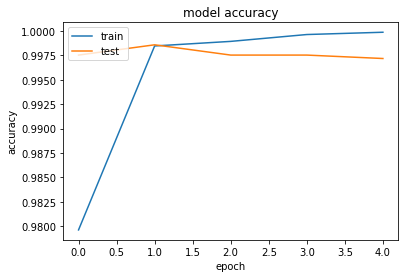

In [22]:
import matplotlib.pyplot as plt
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

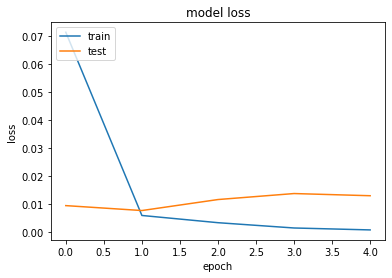

In [23]:
#loss-summary
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
# Predicting the accuracy of the Convolutional Neural Network Model

labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("The accuracy of the CNN model is :- %.2f%%" % (accuracy*100))


The accuracy of the CNN model is :- 99.79%


In [26]:
# Classification report of CNN

print(len(data_test))

print(classification_report(labels_test,labels_pred)) 

print(confusion_matrix(labels_test,labels_pred))

2844
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2382
           1       0.99      0.99      0.99       462

    accuracy                           1.00      2844
   macro avg       1.00      1.00      1.00      2844
weighted avg       1.00      1.00      1.00      2844

[[2379    3]
 [   3  459]]


## Logistic Regression

In [4]:
with h5py.File('train_Data.h5','r') as hdf:
    train_data=hdf.get('train_data')
    labels_data=hdf.get('labels_train')
    dataset1=np.array(train_data)
    dataset2=np.array(labels_data)

In [5]:
with h5py.File('Data_test.h5','r') as hdf:
    data=hdf.get('data_test')
    test=np.array(data)
    data_labels=hdf.get('labels_test')
    test_labels=np.array(data_labels)

In [6]:
class LogReg:
    def __init__(self, l_rate, epochs, n_features):
        self.l_rate = l_rate
        self.epochs = epochs
        self.coef = [0.0] * n_features
        self.bias = 0.0

    def sigmoid(self, score, threshold=20.0):
        if abs(score) > threshold:
            score = threshold * sign(score)
        activation = exp(score)
        return activation / (1.0 + activation)

    def predict(self, features):
        value = sum([features[i]*self.coef[i] for i in range(len(features))]) + self.bias
        return self.sigmoid(value)

    def sg_update(self, features, label):
        yhat = self.predict(features)
        e = label - yhat
        self.bias = self.bias + self.l_rate * e * yhat * (1-yhat)
        for i in range(len(features)):
            self.coef[i] = self.coef[i] + self.l_rate * e * yhat * (1-yhat) * features[i]
        return

    def train(self, X, y):
        for epoch in range(self.epochs):
            for features, label in zip(X, y):
                self.sg_update(features, label)
        return self.bias, self.coef

In [7]:
def get_accuracy(y_bar, y_pred):
    correct = 0
    for i in range(len(y_bar)):
        if y_bar[i] == y_pred[i]:
            correct += 1
    accuracy = (correct / len(y_bar)) * 100.0
    return accuracy

In [8]:
# Logistic Model
logreg = LogReg(0.1, 10, len(dataset1[0]))
bias_logreg, weights_logreg = logreg.train(dataset1, dataset2)
y_logistic = [round(logreg.predict(example)) for example in test]

In [9]:
# Compare accuracies
accuracy_logistic = get_accuracy(test_labels, y_logistic)
print('Logistic Regression Accuracy: {:0.3f}'.format(accuracy_logistic))

Logistic Regression Accuracy: 83.755


In [10]:
print(classification_report(test_labels,y_logistic)) 

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2382
           1       0.00      0.00      0.00       462

    accuracy                           0.84      2844
   macro avg       0.42      0.50      0.46      2844
weighted avg       0.70      0.84      0.76      2844



In [11]:
print(confusion_matrix(test_labels,y_logistic))

[[2382    0]
 [ 462    0]]
